# 基于Python-George库的Gaussian Process Regression实践
#### 赵四维 521021910696
#### 2022-2023-3 SUMMER WEEK2
##### PRP43_基于深度学习的机器人加工颤振在线辨识与智能抑振研究


      小学期开始后，在田学长的指导下，我学习了一些项目相关知识，也进入两微米实验室参观了项目的实验装置。由于近期实验室施工无法线下进行实验操作，故在此学习一些算法推导，也是为后期的实验数据处理作铺垫。
***

   
   高斯过程回归（Gaussian Process Regression, GPR）是一种使用高斯过程（Gaussian Process, GP）先验对数据进行回归分析的非参数模型（non-parameteric model）。回归分析是指通过适当的建模来拟合一组自变量 x 和因变量 y 之间的函数关系。高斯过程是一种随机过程，是一系列符合正态分布的随机变量在一指数集（index set）内的集合，可以用一个均值函数和一个协方差函数来描述。  


   高斯回归过程（GPR）的核心是一个**核函数**,核函数（Kernel function）是一种用来计算两个向量在高维空间中的内积（点积）或者相似度的函数，而不需要显式地将向量映射到高维空间。核函数的作用是将原始的低维空间中的线性不可分的数据，通过一个非线性变换，变换到一个高维的特征空间中，使得数据在高维空间中线性可分，从而可以使用线性分类器或者回归器进行处理。  

   
   根据实验结果和实验要求，可以残用不同的核函数来进行拟合。具体可参考论文《Prediction of in-process frequency response function and chatter stability》。

以下是使用Python的George库进行Gaussian过程回归的一个案例，数据由正弦函数+随机误差生成，而我们的目的是对这15组离散的数据进行GPR拟合。

In [13]:
#检验是否成功安装
import george
george.__version__

'0.4.0'

In [14]:
#生成数据集
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font=FontProperties(fname=r".\Carlito-Italic.ttf",size=14)
np.random.seed(1234)
x = 10*np.sort(np.random.rand(15))
yerr=0.2*np.ones_like(x)
y=np.sin(x)+yerr*np.random.randn(len(x))


Text(0, 0.5, 'y lable')

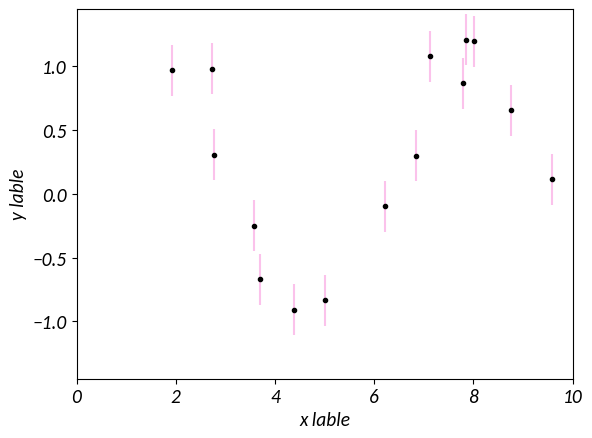

In [15]:
#参数调整&&绘图
plt.errorbar(x,y,yerr=yerr,fmt=".k",capsize=0,ecolor="#fbc2eb")
plt.xlim(0,10)
plt.ylim(-1.45,1.45)
plt.yticks(fontproperties = font, size = 14)
plt.xticks(fontproperties = font, size = 14)
plt.xlabel("x lable",fontproperties=font)
plt.ylabel("y lable",fontproperties=font)

可以看出数据集如上图所示，下面我们进行GPR。选择的核函数为ExpSquaredKernel，它是一种指数平方核函数（Exponential Squared Kernel），也叫高斯核函数（Gaussian Kernel）或者平方指数核函数（Squared Exponential Kernel）。它是一种径向基核函数（Radial Basis Function, RBF），也就是说，它的值只取决于两个向量之间的距离。  

数学公式可以表示为：
$$k(r^2)=e^{-\frac{r^2}{2}}$$
其中$r^2$是两个向量欧氏距离的平方，即
$$r^2=||x-x'||^2$$
ExpSquaredKernel 是一种常用的核函数，可以将数据映射到无穷维空间，适用于模拟具有周期性或者平滑性的函数。它有一个参数，就是距离的缩放因子，也叫做长度尺度（length scale），用来控制核函数的变化速度。长度尺度越大，核函数越平缓；长度尺度越小，核函数越陡峭.

In [16]:
#Gaussian 过程---核和核分解
from george import kernels
kernel=np.var(y)*kernels.ExpSquaredKernel(0.5)
gp=george.GP(kernel)
gp.compute(x,yerr)


In [17]:
#Gaussian Process Regression && prediction
x_pred=np.linspace(0,10,500)
pred,pred_var=gp.predict(y,x_pred,return_var=True)

In [18]:
from matplotlib import font_manager

config = {
    "font.family":'Arial', # sans-serif/serif/cursive/fantasy/monospace
    "font.size": 15, # medium/large/small
    'font.style':'normal', # normal/italic/oblique
    "mathtext.fontset":'cm',# 'cm' (Computer Modern)
    "font.serif": ['cmb10'], # 'Simsun'宋体
    "axes.unicode_minus": False,# 用来正常显示负号
}
plt.rcParams.update(config)

Text(0.5, 1.0, 'GPR Methods')

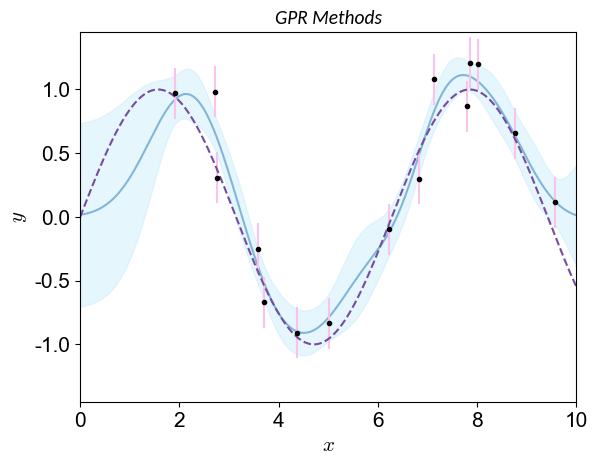

In [19]:
plt.fill_between(x_pred,pred-np.sqrt(pred_var),pred+np.sqrt(pred_var),color="#c2e9fb",alpha=0.4)
plt.plot(x_pred,pred,linewidth=1.5,alpha=0.5)
plt.errorbar(x,y,yerr=yerr,fmt=".k",capsize=0,ecolor="#fbc2eb")
plt.plot(x_pred,np.sin(x_pred),"--",color="#764ba2")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title("GPR Methods",fontproperties=font)

In [20]:
#对数似然函数
print("Initial ln-likelihood:{0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood:-11.82


检验一下，我们再用对数似然函数来估计：

In [21]:
#使用scipy途径来验证
from scipy.optimize import minimize as opt

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = opt(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like,method='BFGS')
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 9.225282556043899
        x: [-4.873e-01  6.041e-01]
      nit: 8
      jac: [-5.070e-06  2.561e-06]
 hess_inv: [[ 5.232e-01  3.004e-01]
            [ 3.004e-01  4.071e-01]]
     nfev: 10
     njev: 10

Final ln-likelihood: -9.23


Text(0.5, 1.0, 'Maximum Likelihood Methods')

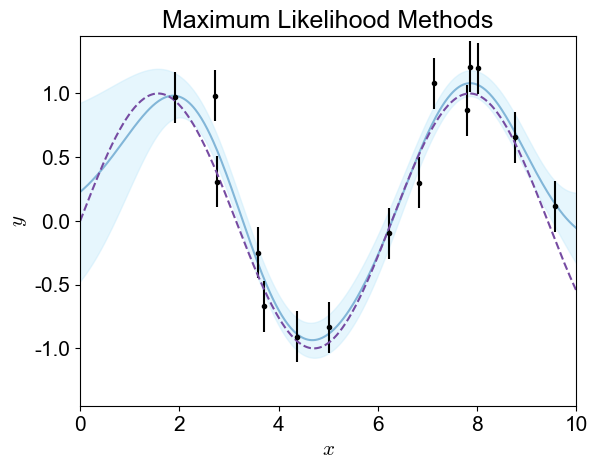

In [22]:
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="#c2e9fb",alpha=0.4)
plt.plot(x_pred, pred, lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--",color="#764ba2")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title("Maximum Likelihood Methods")

可以看到GPR的预测是较为准确的。  

如果我们再试试更多数据（big datasets），分别采用基础GP算法（basic）、近似求解器（HODLRSolver）和scikit-learn（sklearn）进行计算，当数据集不断增大时，比较计算时间，得出不同数据集大小下方法的选择。

### 当数据集较小时：

构造数据集：

In [23]:
import numpy as np
import matplotlib.pyplot as pl

np.random.seed(1234)
x = np.sort(np.random.uniform(0, 10, 50000))
yerr = 0.1 * np.ones_like(x)
y = np.sin(x)

基础方法（basic）：

In [24]:
from george import kernels
kernel = np.var(y) * kernels.ExpSquaredKernel(1.0)

gp_basic = george.GP(kernel)
gp_basic.compute(x[:100], yerr[:100])
print(gp_basic.log_likelihood(y[:100]))

133.9463949119605


近似求解器（hodlrSolver）：

In [25]:
gp_hodlr = george.GP(kernel, solver=george.HODLRSolver, seed=42)
gp_hodlr.compute(x[:100], yerr[:100])
print(gp_hodlr.log_likelihood(y[:100]))

133.9463949119605


scikit-learn（sklearn）：

In [26]:
import sklearn
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

kernel_skl = np.var(y) * RBF(length_scale=1.0)
gp_skl = GaussianProcessRegressor(kernel_skl,
                                  alpha=yerr[:100]**2,
                                  optimizer=None,
                                  copy_X_train=False)
gp_skl.fit(x[:100, None], y[:100])
print(gp_skl.log_marginal_likelihood(kernel_skl.theta))

133.9463949181237


#### 比较时间复杂度：

In [32]:
import time

ns = np.array([50, 100, 200, 500, 1000, 5000, 10000, 50000], dtype=int)
t_basic = np.nan + np.zeros(len(ns))
t_hodlr = np.nan + np.zeros(len(ns))
t_gpy = np.nan + np.zeros(len(ns))
t_skl = np.nan + np.zeros(len(ns))
for i, n in enumerate(ns):
    # Time the HODLR solver.
    best = np.inf
    for _ in range(100000 // n):
        strt = time.time()
        gp_hodlr.compute(x[:n], yerr[:n])
        gp_hodlr.log_likelihood(y[:n])
        dt = time.time() - strt
        if dt < best:
            best = dt
    t_hodlr[i] = best

    # Time the basic solver.
    best = np.inf
    for _ in range(10000 // n):
        strt = time.time()
        gp_basic.compute(x[:n], yerr[:n])
        gp_basic.log_likelihood(y[:n])
        dt = time.time() - strt
        if dt < best:
            best = dt
    t_basic[i] = best

    # Compare to the proposed scikit-learn interface.
    best = np.inf
    if n <= 10000:
        gp_skl = GaussianProcessRegressor(kernel_skl,
                                          alpha=yerr[:n]**2,
                                          optimizer=None,
                                          copy_X_train=False)
        gp_skl.fit(x[:n, None], y[:n])
        for _ in range(10000 // n):
            strt = time.time()
            gp_skl.log_marginal_likelihood(kernel_skl.theta)
            dt = time.time() - strt
            if dt < best:
                best = dt
    t_skl[i] = best

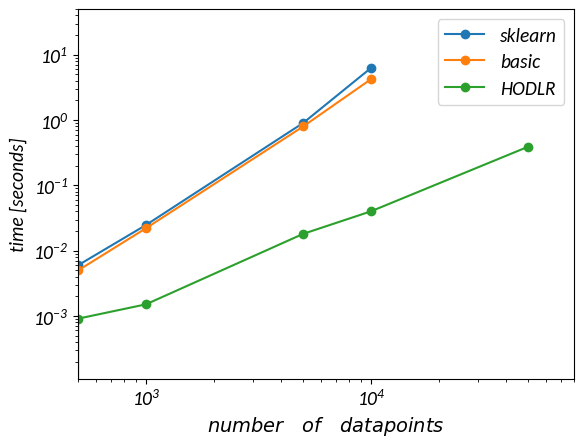

In [50]:
plt.loglog(ns, t_skl, "-o", label="sklearn")
plt.loglog(ns, t_basic, "-o", label="basic")
plt.loglog(ns, t_hodlr, "-o", label="HODLR")
plt.xlim(500, 80000)
plt.ylim(1.1e-4, 50.)
plt.yticks(fontproperties = font, size = 14)
plt.xticks(fontproperties = font, size = 14)
plt.xlabel('$number\quad of\quad datapoints$',fontproperties=font)
plt.ylabel('time [seconds]',fontproperties=font)
plt.legend(loc=2, fontsize=16)
plt.legend(prop=font)


### 算是结论
可以看到其实对于大型数据集$(N\geq 1000)$,HODLRSolver表现非常亮眼。不过我们实验得到的数据集应该不会太大，因此上面的方法我认为都可以选用，甚至我们可以都用作为比较，作为我们项目的一个切入点。

### 题外话
其实可以直接通过MATLAB进行GPR，由于MATLAB封装较为完好，调用方便，在今后实验数据处理上可以直接使用。这几天我没有使用MATLAB而是用Python，一方面是为了更好了解算法原理，算是对此算法的巩固，另一方面也算是对MATLAB计算的有益补充。